# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 0
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states_x = 10
n_states_v = 10
n_actions = 2
n_samples = n_states_x * n_states_v * n_actions
gamma = 0.9

# # Weights collection
n_weights = 1

# # Trainings
layers_dimension = (10,)
max_bellman_iterations = 15
batch_size_samples = n_samples

# ## Linear PBO
training_steps = 100
fitting_steps = 10
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# ## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.01, "last": 0.005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# # Visualisation of errors and performances
horizon = 70

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv

max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

n_samples = n_states_x * n_states_v * n_actions

for state_x in states_x:
    for state_v in states_v:
        state = jnp.array([state_x, state_v])
        
        for action in jnp.arange(n_actions):
            env.reset(state)
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(state, jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

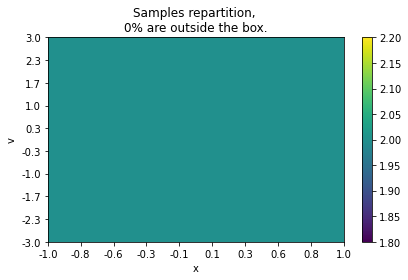

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Optimal Q function

  0%|          | 0/80 [00:00<?, ?it/s]

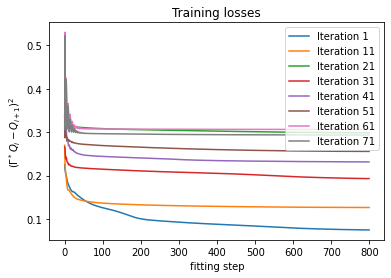

In [5]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_optimal = 80
fitting_steps_q_optimal = 800

data_loader_samples = SampleDataLoader(replay_buffer, n_samples, shuffle_key)
q_optimal = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q_optimal},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

l2_losses = np.ones((max_bellman_iterations_optimal, fitting_steps_q_optimal)) * np.nan

for bellman_iteration in tqdm(range(max_bellman_iterations_optimal)):
    params_target = q_optimal.params
    q_optimal.reset_optimizer()

    for step in range(fitting_steps_q_optimal):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q_optimal.params, q_optimal.optimizer_state, l2_loss = q_optimal.learn_on_batch(q_optimal.params, params_target, q_optimal.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss


for bellman_iteration in range(0, max_bellman_iterations_optimal, 10):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [18]:
env.simulate(q_optimal, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[2.4480896]
[2.0973034]

[-0.5196691 -0.3866922]
[2.835473]
[2.495514]

[-0.57458174 -0.69058496]
[3.1263828]
[2.8473854]

[-0.6524237  -0.83584255]
[3.1444855]
[3.0304604]

[-0.73584473 -0.8066418 ]
[2.9898577]
[3.0737934]

[-0.77940965 -0.07043047]
[2.847269]
[2.8773737]

[-0.75013524  0.6601439 ]
[2.475646]
[2.6205206]

[-0.64621395  1.4185476 ]
[1.7443733]
[2.2109118]

[-0.47197494  1.9924439 ]
[1.3932304]
[3.1669455]

[-0.26982018  1.9430188 ]
[2.2507944]
[2.914527]

[-0.09581636  1.5163397 ]
[2.0734205]
[3.6263866]

[0.03389191 1.1175563 ]
[1.6494131]
[3.6977196]

[0.13404922 0.89555955]
[1.4338293]
[3.6776037]

[0.214388   0.71707237]
[1.2352276]
[3.5250807]

[0.27873483 0.5769776 ]
[1.0860596]
[3.3802423]

[0.33132216 0.4828008 ]
[0.9986372]
[3.4703684]

[0.37691316 0.43707395]
[0.9800701]
[4.0403605]

[0.42033547 0.4393423 ]
[1.0682707]
[5.331051]

[0.4663898  0.48992503]
[1.4869576]
[6.9622974]

[0.52000034 0.5909258 ]
[3.3515835]
[7.933813]

[0.5863459  0.7449882

DeviceArray([ True], dtype=bool)

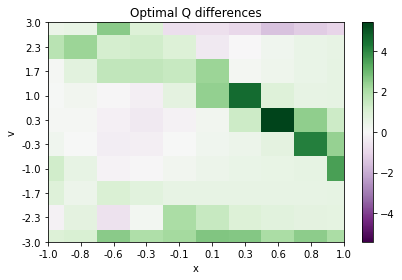

In [7]:
optimal_diff_q = env.diff_q_mesh(q_optimal, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(optimal_diff_q)
q_visu_mesh.show("Optimal Q differences", xlabel="x", ylabel="v")

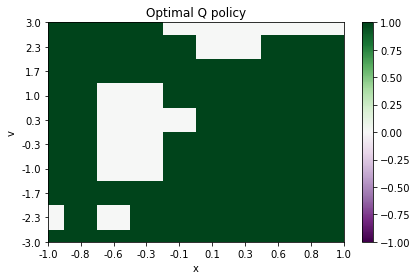

In [8]:
q_visu_mesh.set_values((optimal_diff_q > 0).astype(float))
q_visu_mesh.show("Optimal Q policy", xlabel="x", ylabel="v")

## Train Q with Fitted-Q

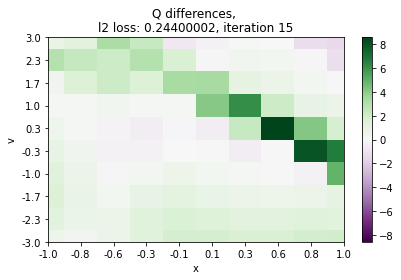

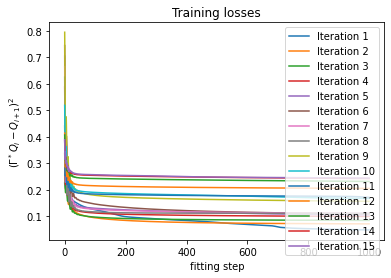

In [9]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q, states_x, states_v)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

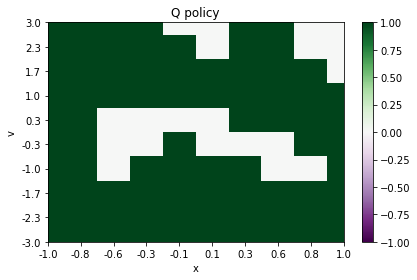

In [10]:
diff_q = env.diff_q_mesh(q, states_x, states_v)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Q policy", xlabel="x", ylabel="v")

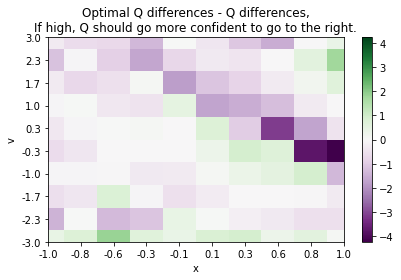

In [11]:
q_visu_mesh.set_values(optimal_diff_q - diff_q)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.", xlabel="x", ylabel="v")

In [19]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[1.6166167]
[1.1920094]

[-0.5196691 -0.3866922]
[1.8504815]
[1.4993505]

[-0.57458174 -0.69058496]
[1.9885173]
[1.8083763]

[-0.6524237  -0.83584255]
[1.9722276]
[2.0560856]

[-0.7017524  -0.14994894]
[2.3383255]
[2.4432411]

[-0.68244594  0.53647816]
[2.3718581]
[2.3889866]

[-0.59486574  1.2045944 ]
[1.4641948]
[2.2289724]

[-0.44820777  1.6645592 ]
[0.63348126]
[2.3314252]

[-0.27860278  1.6479608 ]
[0.55406165]
[2.1472626]

[-0.12895541  1.3209857 ]
[0.9481051]
[2.463368]

[-0.01594389  0.9406348 ]
[1.099767]
[1.9237151]

[0.06269133 0.64848435]
[1.05984]
[1.095048]

[0.11442907 0.38741896]
[0.9592221]
[0.46204758]

[ 0.11791191 -0.31850186]
[0.46494937]
[0.41463566]

[ 0.05186189 -0.99444467]
[-0.2349248]
[0.16247225]

[-0.06294639 -1.3444344 ]
[-0.5522318]
[0.2615428]

[-0.21927896 -1.7740842 ]
[-0.56826067]
[0.612061]

[-0.41031536 -1.9684647 ]
[0.54153776]
[1.4068813]

[-0.591929  -1.5670369]
[1.5914488]
[1.8114586]

[-0.71320754 -0.844229  ]
[1.9108863]
[2.2371564

DeviceArray([ True], dtype=bool)

## Collect weights

In [13]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_pbo = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_pbo.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

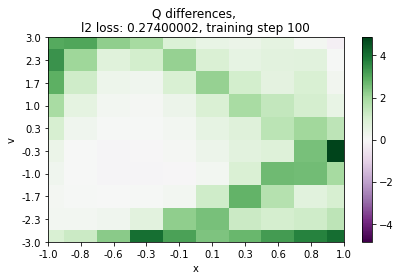

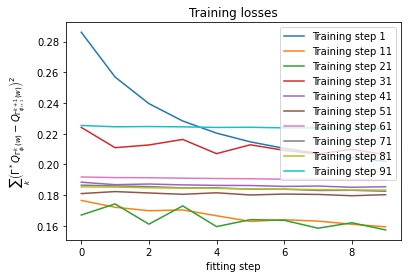

In [27]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q_pbo, max_bellman_iterations, False, pbo_network_key, learning_rate)  # add_infinity == False
importance_iteration = jnp.ones(max_bellman_iterations + 1)
# importance_iteration = importance_iteration.at[-1].set(0)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    # pbo.reset_optimizer()

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss

    q_weight = validation_initial_weight
    for _ in range(max_bellman_iterations):
        q_weight = pbo(pbo.params, q_weight)
    q_pbo.params = q.to_params(q_weight)
    diff_q_pbo = env.diff_q_mesh(q_pbo, states_x, states_v)

    q_visu_mesh.set_values(diff_q_pbo)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, 10):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

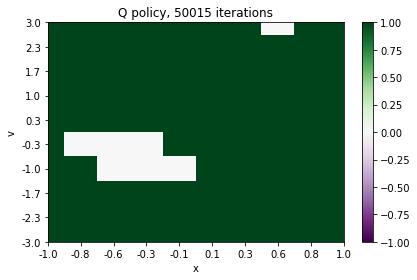

In [36]:
test_bellman_iterations = max_bellman_iterations + 50000

q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)
diff_q_pbo = env.diff_q_mesh(q_pbo, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values((diff_q_pbo > 0).astype(float))
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

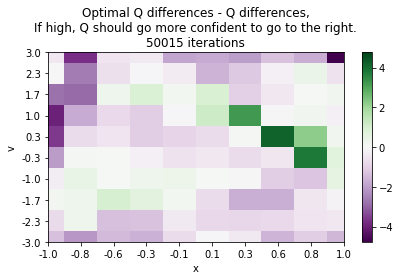

In [37]:
q_visu_mesh.set_values(optimal_diff_q - diff_q_pbo)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.\n{test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [38]:
q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)

# q_pbo.params = q_pbo.to_params(pbo.fixed_point(pbo.params))


env.simulate(q_pbo, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[-0.35062075]
[-0.33149958]

[-0.4803309  0.3866922]
[-0.34731388]
[0.05444384]

[-0.4254183  0.690585 ]
[0.07286596]
[0.76369286]

[-0.34757635  0.83584267]
[0.69366646]
[1.5237107]

[-0.2641553   0.80664194]
[1.1852069]
[1.9811089]

[-0.19029287  0.65616035]
[1.4047904]
[2.1616442]

[-0.13487127  0.44623253]
[1.4107337]
[2.1664832]

[-0.10178459  0.2134663 ]
[1.2421899]
[2.0259705]

[-0.09239412 -0.02605632]
[0.9049816]
[1.7159269]

[-0.10697368 -0.26488298]
[0.5054226]
[1.204227]

[-0.14507785 -0.494572  ]
[0.33378744]
[0.5523138]

[-0.20496078 -0.69564986]
[0.100842]
[-0.0264473]

[-0.3142061 -1.4989252]
[-0.23794746]
[-0.15468168]

[-0.46343502 -1.4154499 ]
[-0.21537256]
[-0.18160772]

[-0.584235   -0.95343065]
[-0.17485619]
[-0.3866601]

[-0.6854406 -1.0309224]
[-0.15588236]
[-0.15705204]

[-0.7836688  -0.90837353]
[-0.05160522]
[0.05788231]

[-0.8361219  -0.15135974]
[0.5058837]
[0.8970394]

[-0.81459767  0.5865607 ]
[0.79252815]
[2.4800825]

[-0.7165754  1.3873893]


DeviceArray([ True], dtype=bool)